$\newcommand{\calf}{{\cal F}}
\newcommand{\dnu}{d \nu}
\newcommand{\dmu}{d \mu}
\newcommand{\dmup}{d \mu'}
\newcommand{\vf}{{\bf f}}
\newcommand{\vq}{{\bf q}}
\newcommand{\mg}{{\bf G}}
\newcommand{\mK}{{\bf K}}$

In [1]:
include("nda_note.jl")

# Problems with NDA and QMC

Here are the things I've been doing to figure out what the problems are.

The first thing is to see if the low-order problem is correct. I know that the QMC code is returning good cell-average fluxes because I'm getting good results with the Krylov solves. So I will check the coefficients and boundary conditions of the low-order problem

$$
\frac{d}{dx}\left[ -\frac{1}{3\Sigma_t} \frac{d\phi}{dx} + \hat{D} \phi\right] + (\Sigma_t - \Sigma_s)\phi = q,
$$
with boundary conditions $\phi(0)=\phi^{HO}(0)$ and $\phi(\tau)=\phi^{HO}(\tau)$. For our example $q=0$.

The coefficient is
$$
{\hat D} = \frac{ J^{HO} + \frac{1}{3} \frac{d \phi^{HO}}{dx} } {\phi^{HO}},
$$

In my formulation $\hat D$ is a cell-average qantity and the low-order flux $\phi$ is a cell edge quantity.
As you saw from my email of July 13, the QMC code returns strange cell-edge valueds for the flux. The QMC code then differentiaes the edge values numerically to get $d \phi/dx$. NDA with that $d \phi/dx$ diverges.

I fixed(?) that by taking using the cell averages to get cell edges and then differentiate that numerically. The Julia code for that is
```Jullia
function avg2edge!(phi_edge, dphi, phi_avg, dx)
Nx=length(phi_avg)
m=length(phi_edge)
Nx==length(dphi) || error("dphi lives on cell centers")
m == Nx+1 || error("edges and averages fail to match")
phi_edge[1]=1.5*phi_avg[1] - .5*phi_avg[2]
for ie=2:Nx
phi_edge[ie] = .5*(phi_avg[ie-1]+phi_avg[ie])
end
phi_edge[Nx+1]=1.5*phi_avg[Nx] - .5*phi_avg[Nx-1]
for id=1:Nx
dphi[id]=(phi_edge[id+1]-phi_edge[id])/dx
end
return (phi_edge=phi_edge, dphi=dphi)
end
```
The NDA iteration no longer diverges, but the solution is terrible and is discontinuous at the right boundary. Here's a plot. I'm using my very questionable implementation ```qmc_nda.jl``` for this. All the codes I use for QMC work in this note book are in the __src/Tim_QMC__ directory. 

Here are a few sanity checks to see what the fluxes and the derivative $d \phi/dx$ look like. I'll repeat
the computation from the email first and them compare my fix to what I get from a standard SN transport sweep. Here's the script and plot from the email.

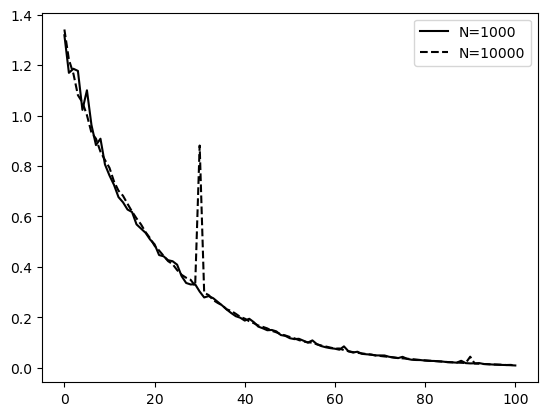

PyObject <matplotlib.legend.Legend object at 0x14fd019f0>

In [2]:
Nx=100;
na2=11;
s=1.0;
phit=ones(Nx,);
data1=qmc_init(1000,Nx,na2,s);
data2=qmc_init(10000,Nx,na2,s);
phiout1=qmc_sweep(phit, data1);
phiout2=qmc_sweep(phit, data2);
plot(phiout1.phi_edge,"k-");
plot(phiout2.phi_edge,"k--");
legend(["N=1000", "N=10000"])